In [628]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [629]:


import pyspiel
import open_spiel.python.games
from open_spiel.python.observation import make_observation
from open_spiel.python.examples.ubc_decorators import TakeSingleActionDecorator
from open_spiel.python.examples.straightforward_agent import StraightforwardAgent
from open_spiel.python.pytorch.mutations import *
from open_spiel.python.examples.ppo_utils import EnvParams
from open_spiel.python.examples.ppo_eval import eval_agents_parallel
from open_spiel.python.env_decorator import *

from auctions.webutils import *
import os
os.environ["DJANGO_ALLOW_ASYNC_UNSAFE"] = "true"

import sys
import glob
import pandas as pd
import os
import seaborn as sns

from tqdm import tqdm
from statsmodels.distributions.empirical_distribution import ECDF
from collections import defaultdict
import pickle
import re
import json
import numpy as np 
import pandas as pd
from absl import logging
import tempfile
import subprocess

import open_spiel.python.games
from open_spiel.python.examples.ubc_utils import *
from open_spiel.python.algorithms.exploitability import nash_conv, best_response

import bokeh
from bokeh.io import curdoc
from bokeh.plotting import figure, show, output_file, save
from bokeh.layouts import row, column
from bokeh.io import output_notebook
from bokeh.models import HoverTool, ColumnDataSource, ColorBar, LogColorMapper, LinearColorMapper
from bokeh.transform import linear_cmap, log_cmap, factor_cmap
from bokeh.palettes import Category10_10, Magma256, Spectral10, Category20_20
from bokeh.models import LinearAxis, Range1d
from bokeh.models import ColumnDataSource, FactorRange

from bokeh.resources import CDN
from bokeh.embed import file_html

from pathlib import Path

import matplotlib.pyplot as plt
import seaborn as sns
from django.db.models import F
from auctions.models import *

import bokeh
from bokeh.layouts import row, column
from bokeh.plotting import figure, show, output_file, save
from bokeh.io import output_notebook
from bokeh.models import HoverTool, ColumnDataSource, ColorBar, LogColorMapper, LinearColorMapper
from bokeh.transform import linear_cmap, log_cmap
from bokeh.palettes import Category10_10, Magma256, Spectral10, Category20_20
os.environ["DJANGO_ALLOW_ASYNC_UNSAFE"] = "true"
from open_spiel.python.examples.ubc_cma import *

import itertools
output_notebook()
from open_spiel.python.examples.ubc_cma import *
from open_spiel.python.examples.env_and_policy import *
from open_spiel.python.examples.ppo_eval import run_eval
from open_spiel.python.examples.straightforward_agent import StraightforwardAgent

Loading BokehJS ...

In [1296]:
# GAME_NAME = 'confused_national'
# GAME_NAME = 'all_confused_with_local'
# GAME_NAME = '2rvn'
# GAME_NAME = 'all_confused'
GAME_NAME = 'regional_vs_national'

PYSATS = '/apps/sats/python'
!python {PYSATS}/pysats.py --config_file {PYSATS}/{GAME_NAME}.yml --seed 777 --output_file {PYSATS}/{GAME_NAME}.json
GAME_NAME = f'{PYSATS}/{GAME_NAME}'

{'licenses': [3, 3, 3], 'activity': [5, 14, 8], 'opening_price': [50, 700, 250], 'information_policy': 'show_demand', 'undersell_rule': 'undersell', 'increment': 0.1, 'license_names': ['British Columbia', 'Ontario', 'Quebec'], 'players': [{'type': [{'value': [0, 514, 979, 1560, 1499, 2014, 2479, 3059, 2856, 3370, 3835, 4416, 4550, 5064, 5529, 6110, 321, 835, 1300, 1881, 1821, 2335, 2800, 3381, 3177, 3692, 4157, 4737, 4871, 5385, 5850, 6431, 612, 1126, 1591, 2172, 2111, 2626, 3091, 3671, 3468, 3982, 4447, 5028, 5162, 5676, 6141, 6722, 975, 1489, 1954, 2535, 2474, 2989, 3454, 4034, 3831, 4345, 4810, 5391, 5525, 6039, 6504, 7085], 'value_format': 'full', 'budget': 7085, 'prob': 0.5, 'name': 'regional'}, {'value': [0, 280, 486, 691, 491, 1802, 2282, 2759, 852, 2643, 3124, 3601, 1209, 3477, 3958, 4435, 175, 1064, 1545, 2022, 1556, 2632, 3205, 3772, 2397, 3634, 4207, 4774, 3231, 4627, 5200, 5767, 304, 1365, 1846, 2322, 1856, 2990, 3563, 4130, 2698, 3992, 4564, 5132, 3532, 4985, 5557, 6125, 4

In [1297]:
# # GAME_NAME = 'sats_2regions_2licenses_2players_5types'
# GAME_NAME = 'confused_national'
# # GAME_NAME = '/apps/sats/python/regional_vs_national'

In [1309]:
game = pyspiel.load_game('python_clock_auction', dict(filename=f'{GAME_NAME}.json'))

In [1310]:
# FACTOR_OPENING_PRICES = True
FACTOR_OPENING_PRICES = False

In [1311]:
# Stuff that doesn't chagne per player
packages = game.auction_params.all_bids
pure_packages_indices = np.where(np.count_nonzero(packages, axis=1) == 1)
pure_packages = packages[pure_packages_indices]
products = [num_to_letter(i) for i in range(game.auction_params.num_products)]
quantities = list(map(str, range(1, max(game.auction_params.licenses) + 1)))
max_quantity = max(game.auction_params.licenses)
colors = Category10_10[:len(quantities)]
player_types = game.auction_params.player_types

# TODO: Should assert this only works for Enumerated Bidder
for player_index, player_type in player_types.items():
    num_types = len(player_types[player_index])

    records = []
    
    num_types = len(player_types[player_index])

    for type_index in range(num_types):
        bidder = player_types[player_index][type_index]['bidder']
        values = bidder.get_profits(game.auction_params.opening_prices) if FACTOR_OPENING_PRICES else bidder.get_values()
        values = values[pure_packages_indices]
        
        for package_index, pure_package in enumerate(pure_packages):
            product_index = np.nonzero(pure_package)[0][0]
            q = pure_package[product_index]
            record = dict(x=(game.auction_params.license_names[product_index], bidder.name or str(type_index)), q=q, value=values[package_index])
            records.append(record)
    
    df = pd.DataFrame.from_records(records).pivot(index='x', columns='q')
    df.columns = map(str,df.columns.get_level_values(1))
    df = df.reset_index()
    marginal_df = df.copy()
    marginal_df["1"] = np.maximum(marginal_df["1"], 0)
    for z in range(2, max_quantity + 1):
        marginal_df[str(z)] = np.maximum(0, df[str(z)] - df[str(z - 1)])

    df = marginal_df
    
    if not FACTOR_OPENING_PRICES and (df.select_dtypes(include=np.number) < 0).sum().sum():
        # for pkg, val in zip(game.auction_params.all_bids,bidder.values):
        #     print(pkg, val)
        raise ValueError("No negative numbers expected!")
    
    source = ColumnDataSource(df)
    factors = df['x'].values

    p = figure(x_range=FactorRange(*factors), height=250, toolbar_location=None, tools="hover", tooltips="$name: @$name")

    p.vbar_stack(quantities, x='x', width=0.9, alpha=0.5, color=colors, source=source, legend_label=quantities)

    # p.y_range.start = 0
    # p.y_range.end = 18
    p.x_range.range_padding = 0.1
    p.xaxis.major_label_orientation = 1
    p.xgrid.grid_line_color = None
    p.legend.location = "top_center"
    p.legend.click_policy = 'mute'
    p.legend.orientation = "horizontal"
    p.add_layout(p.legend[0], 'right')
    p.title.text = f'Player {player_index}'

    # TODO: Add total value to hover, not just marginal
    show(p)


In [1312]:
df, combo_to_score, scorer = efficient_allocation(game, factor_in_opening_prices=FACTOR_OPENING_PRICES)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 38.76it/s]


In [1313]:
worst_case_profit, allocation = efficient_allocation_avg_type(game, factor_in_opening_prices=FACTOR_OPENING_PRICES)

In [1314]:
allocation

[array([1, 2, 2]), array([2, 1, 1])]

In [1315]:
worst_case_profit / df['score'].mean()

0.9653362795194034

In [1316]:
worst_case_profit

6990.0

In [1317]:
df['score'].mean()

7241.0

In [1318]:
df

,prob,score,allocation,combo
0,0.25,7085.0,"((0, 3, 0), (3, 0, 3))","(0, 0)"
1,0.25,7341.0,"((0, 2, 0), (3, 1, 3))","(0, 1)"
2,0.25,7341.0,"((3, 1, 3), (0, 2, 0))","(1, 0)"
3,0.25,7197.0,"((1, 1, 2), (2, 2, 1))","(1, 1)"


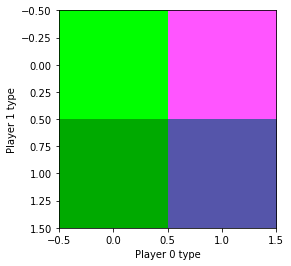

In [1319]:
# TODO: Only works for 2p
df[['p0_type', 'p1_type']] = pd.DataFrame(df['combo'].apply(lambda x: x[:2]).tolist())
df[['p0_allocation', 'p1_allocation']] = pd.DataFrame(df['allocation'].apply(lambda x: x[:2]).tolist())
df[['r', 'g', 'b']] = pd.DataFrame(df['p0_allocation'].tolist()) / 3

plt_rgb = df[['r', 'g', 'b']].values
plt_x = df['p0_type'].values
plt_y = df['p1_type'].values
plt_colors = np.zeros((max(plt_x)+1, max(plt_y)+1, 3))
plt_colors[plt_y, plt_x, :] = plt_rgb
plt.imshow(plt_colors, interpolation='nearest')
plt.xlabel('Player 0 type')
plt.ylabel('Player 1 type')
plt.show()

In [974]:
plt_colors[1, 2]

array([1. , 1. , 0.5])

In [973]:
plt_colors[0, 2]

array([1., 1., 0.])

In [913]:
df

,prob,score,allocation,combo,p0_type,p1_type,p0_allocation,p1_allocation,r,g,b
0,0.04,1423.0,"((1, 0, 2), (1, 2, 0))","(0, 0)",0,0,"(1, 0, 2)","(1, 2, 0)",0.5,0.0,1.0
1,0.04,713.0,"((0, 0, 2), (2, 2, 0))","(0, 1)",0,1,"(0, 0, 2)","(2, 2, 0)",0.0,0.0,1.0
2,0.04,757.0,"((1, 0, 2), (0, 2, 0))","(0, 2)",0,2,"(1, 0, 2)","(0, 2, 0)",0.5,0.0,1.0
3,0.04,695.0,"((0, 1, 2), (2, 0, 0))","(0, 3)",0,3,"(0, 1, 2)","(2, 0, 0)",0.0,0.5,1.0
4,0.04,1235.0,"((1, 0, 2), (1, 2, 0))","(0, 4)",0,4,"(1, 0, 2)","(1, 2, 0)",0.5,0.0,1.0
5,0.04,928.0,"((2, 0, 0), (0, 2, 1))","(1, 0)",1,0,"(2, 0, 0)","(0, 2, 1)",1.0,0.0,0.0
6,0.04,419.0,"((0, 0, 0), (2, 2, 2))","(1, 1)",1,1,"(0, 0, 0)","(2, 2, 2)",0.0,0.0,0.0
7,0.04,352.0,"((2, 0, 0), (0, 2, 0))","(1, 2)",1,2,"(2, 0, 0)","(0, 2, 0)",1.0,0.0,0.0
8,0.04,211.0,"((0, 0, 0), (2, 0, 0))","(1, 3)",1,3,"(0, 0, 0)","(2, 0, 0)",0.0,0.0,0.0
9,0.04,1084.0,"((2, 0, 0), (0, 2, 2))","(1, 4)",1,4,"(2, 0, 0)","(0, 2, 2)",1.0,0.0,0.0


In [612]:
df['allocation'].value_counts()

((1, 0, 1), (1, 2, 1))    5
((1, 0, 2), (1, 2, 0))    4
((0, 0, 0), (2, 2, 2))    2
((2, 1, 1), (0, 1, 1))    2
((1, 1, 2), (1, 1, 0))    2
((0, 0, 2), (2, 2, 0))    2
((1, 0, 0), (1, 2, 1))    1
((2, 1, 0), (0, 1, 2))    1
((2, 0, 1), (0, 2, 1))    1
((0, 0, 0), (2, 2, 1))    1
((1, 0, 0), (1, 2, 2))    1
((1, 2, 1), (1, 0, 1))    1
((2, 2, 1), (0, 0, 1))    1
((1, 1, 1), (1, 1, 1))    1
Name: allocation, dtype: int64

In [269]:
a = game.auction_params.player_types[0][0]['bidder'].value_for_package([1,2,1])
b = game.auction_params.player_types[1][0]['bidder'].value_for_package([2,1,2])
print(a, b, a+b)

16346 9931 26277


In [270]:
a = game.auction_params.player_types[0][0]['bidder'].value_for_package([0,2,0])
b = game.auction_params.player_types[1][0]['bidder'].value_for_package([3,1,3])
print(a, b, a+b)

IndexError: index 0 is out of bounds for axis 0 with size 0

In [ ]:
game.auction_params.player_types[1][0]['bidder'].value_for_package([3,0,0])

In [ ]:
df

In [ ]:
from open_spiel.python.examples.ubc_cma import *
from open_spiel.python.examples.env_and_policy import *
from open_spiel.python.examples.ppo_eval import run_eval
from open_spiel.python.examples.straightforward_agent import StraightforwardAgent

In [ ]:
game.auction_params.increment = 0.05

In [ ]:
all_allocations = []
for combo in tqdm(type_combos(game)):
    history_prefix = [combo[p]['index'] for p in range(game.num_players())]
    named_combo = [combo[p]['bidder'].name for p in range(game.num_players())]
    env = EnvParams(track_stats=True, history_prefix=history_prefix, num_envs=1, normalize_rewards=False).make_env(game)
    env_and_policy = EnvAndPolicy(env=env, agents=[StraightforwardAgent(0, game), StraightforwardAgent(1, game)], game=game)
    evaluation = run_eval(env_and_policy, num_samples=10)
    allocations = []
    for player in range(game.num_players()):
        allocation = np.array(evaluation['allocations'][player]).mean(axis=0)
        allocations.append(allocation)
    all_allocations.append((named_combo, np.round(allocations, 2)))

In [ ]:
all_allocations

In [ ]:
# Iterate over cartesian product of types


In [ ]:
history_prefix = [1,1]
named_combo = ['n', 'n']
env = EnvParams(track_stats=True, history_prefix=history_prefix, num_envs=1, normalize_rewards=False).make_env(game)
env_and_policy = EnvAndPolicy(env=env, agents=[StraightforwardAgent(0, game), StraightforwardAgent(1, game)], game=game)
evaluation = run_eval(env_and_policy, num_samples=2)


In [ ]:
x = [(1,2,3), (4,5,6)]
for item in x:
    x.remove((4,5,6))

In [ ]:
x